In [1]:
#import packages
import pandas as pd
import numpy as np
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('stock_price_list',delimiter='\t')

#print the head
df.head()

,Date,AAPL,AMFE,ASNT,AVEO,BOXL,CEI,COOP,CRMD,CSRH,...,NVDA,OACQ,ORC,RIBT,RNWR,ROX,SYCRF,TPL,VCSY,WYNN
0,2014-01-02,79.018570,0.0095,NaN,1.80,NaN,612.50,34.439999,1.36,0.009,...,15.860000,NaN,13.23,5.19,NaN,0.71,0.73,99.500000,0.0609,197.940002
1,2014-01-03,77.282860,0.0090,NaN,1.85,NaN,612.50,35.280003,1.49,0.009,...,15.670000,NaN,13.39,5.48,NaN,0.78,0.77,99.500000,0.0650,196.000000
2,2014-01-06,77.704285,0.0090,NaN,1.80,NaN,618.75,33.000000,1.46,0.009,...,15.880000,NaN,13.42,5.34,NaN,0.76,0.75,99.570000,0.0640,195.860001
3,2014-01-07,77.148575,0.0090,NaN,1.78,NaN,618.75,32.280003,1.50,0.009,...,16.139999,NaN,13.23,5.66,NaN,0.77,0.85,98.650002,0.0630,201.509995
4,2014-01-08,77.637146,0.0095,NaN,1.78,NaN,625.00,32.160000,1.60,0.009,...,16.360001,NaN,13.38,5.59,NaN,0.81,0.85,98.449997,0.0600,205.289993


In [2]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['AAPL'][i]

In [3]:
#create features
from fastai.structured import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

/Users/wyc/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']


In [6]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [8]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

47.8329214130354

/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


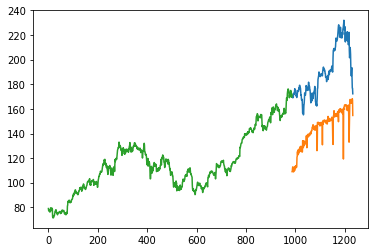

In [9]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])